
# 📊 Proyecto de Análisis de Sentimientos de Tweets

## 🎯 Problema de Negocio

El objetivo de este proyecto es analizar los sentimientos de los tweets, identificando si los mensajes son positivos o negativos. Utilizando un conjunto de datos de 1,600,000 tweets preprocesados, se pretende generar diversas características que se utilizarán para entrenar un modelo de clasificación.

## ❓ Preguntas Clave

- **¿Qué variables pueden ser clave para la detección del sentimiento?**
- **¿Qué tipo de modelos pueden servir para detectar el sentimiento en los tweets?**
- **¿Qué métricas se pueden utilizar para evaluar el desempeño del modelo?**

In [ ]:
# @title
!pip install nltk
!pip install emoji
!pip install numpy pandas seaborn matplotlib scikit-learn
!pip install langdetect
!pip install langid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=92791c6b09c742602c4267510b2f3f0a3f3619dca71d82510664a2ca3851a074
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=ddd49ecee926928b941a266aecbdaaf42aca8590666c749b9d154150dd429b4d
  Stored in directory: /root/.cache/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built langid


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata
import string
import emoji
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from langdetect import detect, detect_langs
from multiprocessing import Pool
import langid
import nltk
import math
nltk.download('stopwords')
from collections import Counter

# Cargar el dataset de tweets
df = pd.read_csv("/content/training_1600000_processed_noemoticon.csv", encoding = 'latin-1')
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df.info()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   ids     1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
# Función para contar caracteres no ASCII
def count_non_ascii_chars(text):
    return sum(1 for char in text if ord(char) > 127)

# Aplicar la función al DataFrame
df['non_ascii_count'] = df['text'].apply(count_non_ascii_chars)

# Imprimir la cantidad de registros que contienen caracteres no ASCII
non_ascii_count = df[df['non_ascii_count'] > 0].shape[0]
print(f'Cantidad de registros con caracteres no ASCII: {non_ascii_count}')

Cantidad de registros con caracteres no ASCII: 14538


In [ ]:
df = df[df['non_ascii_count'] == 0]

In [ ]:
df = df.drop(columns=['non_ascii_count'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1585461 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1585461 non-null  int64 
 1   ids     1585461 non-null  int64 
 2   date    1585461 non-null  object
 3   flag    1585461 non-null  object
 4   user    1585461 non-null  object
 5   text    1585461 non-null  object
dtypes: int64(2), object(4)
memory usage: 84.7+ MB


El dataset contiene texto que se puede considerar como "sucio", es por ello que partamos de crear una función que pueda limpiar este texto eliminando URLs, menciones, emojis y caracteres especiales.
Recuerda que la limpieza de texto es crucial para que el análisis sea más preciso.

In [ ]:
def clean_text(text):
    # Normalización Unicode
    text = unicodedata.normalize('NFKD', text)
    # Eliminar caracteres no alfabéticos
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Eliminar espacios al inicio y al final y normalizar espacios múltiples
    text = ' '.join(text.split())
    #Eliminar urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Eliminar caracteres especiales
    text = re.sub(r'[^\w\s]', '', text)
    # Eliminar menciones
    text = re.sub(r'@\w+', '', text)
    # Eliminar emojis del tweet original.
    text = emoji.demojize(text)
    return text
df['cleaned_text'] = df['text'].apply(clean_text)

In [ ]:
# @title
# # PROCESAMIENTO Y ANÁLISIS DE TEXTO PARA EXTRACCIÓN DE CARACTERÍSTICAS
# # Este script realiza varias operaciones de procesamiento de lenguaje natural (NLP)
# # Verificación y descarga de recursos necesarios de NLTK

# try:
#     nltk.data.find('wordnet')                      # Verifica si WordNet está disponible
#     nltk.data.find('omw-1.4')                      # Verifica si Open Multilingual WordNet está disponible
# except LookupError:
#     nltk.download('wordnet')                       # Descarga WordNet si no está disponible
#     nltk.download('omw-1.4')                       # Descarga OMW si no está disponible

# # Inicialización del lematizador
# lemmatizer = WordNetLemmatizer()                   # Crea una instancia del lematizador


# # Función para lematización: reduce las palabras a su forma base
# def lemmatize_text(text):
#     """
#     Convierte cada palabra del texto a su forma base (lema).
#     Ejemplo: 'corriendo' -> 'correr', 'mejores' -> 'mejor'

#     Args:
#         text (str): Texto a lematizar

#     Returns:
#         str: Texto con palabras lematizadas
#     """
#     words = text.split()                           # Divide el texto en palabras individuales
#     lemmatized_words = [lemmatizer.lemmatize(word) for word in words]   # Lematiza cada palabra
#     return " ".join(lemmatized_words)              # Une las palabras lematizadas con espacios

# # Aplicación de la lematización a la columna de texto limpio
# df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)


# # Función para generar bigramas: crea pares de palabras consecutivas
# def generate_bigrams(text):
#     """
#     Genera bigramas (pares de palabras consecutivas) a partir del texto.
#     Ejemplo: "me gusta comer" -> ["me gusta", "gusta comer"]

#     Args:
#         text (str): Texto del cual generar bigramas

#     Returns:
#         list: Lista de bigramas generados
#     """
#     words = text.split()                           # Divide el texto en palabras
#     bigrams_list = list(ngrams(words, 2))          # Genera los bigramas (tuplas de 2 palabras)
#     return [" ".join(bigram) for bigram in bigrams_list]  # Convierte cada bigrama en string

# # Aplicación de la generación de bigramas a la columna de texto lematizado
# df['bigrams'] = df['lemmatized_text'].apply(generate_bigrams)


# # Definición de listas de palabras por categoría de sentimiento
# positive_words = ['good', 'great', 'happy', 'love', 'amazing', 'awesome', 'fantastic', 'joy', 'wonderful', 'brilliant', 'success', 'beautiful', 'nice', 'positive' ] # Ejemplo de palabras positivas.
# negative_words = ['bad', 'sad', 'angry', 'hate', 'awful', 'worst', 'disappointing', 'ugly', 'failure', 'disaster', 'problem', 'annoying', 'negative' ] # Ejemplo de palabras  negativas.
# neutral_words = ['the', 'a', 'is', 'are'] # Ejemplo de palabras neutras.

# # Función para contar palabras específicas en un texto
# def count_words(text, word_list):
#     """
#     Cuenta cuántas palabras de una lista específica aparecen en el texto.

#     Args:
#         text (str): Texto donde buscar las palabras
#         word_list (list): Lista de palabras a contar

#     Returns:
#         int: Número de palabras encontradas
#     """
#     words = text.split()                           # Divide el texto en palabras
#     return sum(1 for word in words if word in word_list)  # Cuenta las coincidencias

# # Aplicación del conteo de palabras por categoría
# df['positive_word_count'] = df['lemmatized_text'].apply(lambda x: count_words(x, positive_words))
# df['negative_word_count'] = df['lemmatized_text'].apply(lambda x: count_words(x, negative_words))
# df['neutral_word_count'] = df['lemmatized_text'].apply(lambda x: count_words(x, neutral_words))


# # TF-IDF asigna pesos a las palabras basándose en su frecuencia en el documento
# # y su rareza en el corpus completo.
# # Palabras comunes en un documento pero raras en general reciben pesos mayores.

# # Inicialización del vectorizador TF-IDF
# tfidf_vectorizer = TfidfVectorizer()              # Crea una instancia del vectorizador

# # Vectorización TF-IDF para textos lematizados
# tfidf_lemmas = tfidf_vectorizer.fit_transform(df['lemmatized_text'])  # Ajusta y transforma los textos
# df['tfidf_lemmas'] = list(tfidf_lemmas)           # Guarda los vectores resultantes

# # Vectorización TF-IDF para bigramas
# # Nota: requiere convertir las listas de bigramas a strings ya que TfidfVectorizer no acepta listas
# df['bigrams_str'] = df['bigrams'].apply(lambda x: " ".join(x))  # Convierte listas a strings
# tfidf_bigrams = tfidf_vectorizer.fit_transform(df['bigrams_str'])  # Ajusta y transforma
# df['tfidf_bigrams'] = list(tfidf_bigrams)         # Guarda los vectores resultantes

In [ ]:
# @title
# # Convertir las matrices TF-IDF a arrays densos
# tfidf_lemmas_array = tfidf_lemmas.toarray()
# tfidf_bigrams_array = tfidf_bigrams.toarray()

# # Convertir los arrays a DataFrames de Pandas
# tfidf_lemmas_df = pd.DataFrame(tfidf_lemmas_array)
# tfidf_bigrams_df = pd.DataFrame(tfidf_bigrams_array)

# # Agregar prefijos a las columnas para evitar conflictos
# tfidf_lemmas_df.columns = [f'tfidf_lemma_{i}' for i in range(tfidf_lemmas_df.shape[1])]
# tfidf_bigrams_df.columns = [f'tfidf_bigram_{i}' for i in range(tfidf_bigrams_df.shape[1])]

# # Concatenar los DataFrames de TF-IDF con el DataFrame principal
# df = pd.concat([df, tfidf_lemmas_df, tfidf_bigrams_df], axis=1)

# # Mostrar las primeras filas del DataFrame resultante
# print(df.head())

In [ ]:
df.head()

,target,ids,date,flag,user,text,cleaned_text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,Kwesidei not the whole crew


In [ ]:
def detectar_idioma(text):
    try:
        return langid.classify(text)[0]
    except:
        return 'unknown'

# Función para aplicar la detección de idioma a todo el DataFrame
def apply_langdetect(df):
    df['idioma'] = df['cleaned_text'].apply(detectar_idioma)
    return df

# Aplicar la detección de idioma
df = apply_langdetect(df)

# Obtener los valores únicos de la columna idioma
valores_unicos_idioma = df['idioma'].unique()
print(f'Valores únicos de la columna idioma: {valores_unicos_idioma}')

# Contar la cantidad de registros para cada idioma
conteo_idiomas = df['idioma'].value_counts()
print(conteo_idiomas)

Valores únicos de la columna idioma: ['en' 'es' 'cy' 'eu' 'fr' 'de' 'fi' 'pt' 'sv' 'da' 'it' 'lv' 'nl' 'xh'
 'af' 'et' 'ro' 'no' 'mt' 'id' 'nb' 'ms' 'pl' 'br' 'mg' 'sw' 'nn' 'cs'
 'sl' 'la' 'tl' 'ca' 'tr' 'oc' 'az' 'an' 'rw' 'hu' 'ga' 'wa' 'hr' 'lt'
 'ku' 'vi' 'vo' 'lb' 'bs' 'sk' 'sq' 'eo' 'zu' 'jv' 'se' 'gl' 'zh' 'ht'
 'qu' 'fo' 'is' 'ky' 'ar']
idioma
en    1505981
de      10912
es       7461
it       6392
fr       5749
       ...   
zh         24
is         19
fo         13
ky          2
ar          2
Name: count, Length: 61, dtype: int64


Podemos observar que tenemos muchos tweets en distintos idiomas, veamos su proporción.

In [ ]:
# Calcular el porcentaje de cada idioma
conteo_idiomas = df['idioma'].value_counts()
proporcion_idiomas = (conteo_idiomas / len(df)) * 100

# Imprimir la proporción de cada idioma
print(proporcion_idiomas)

idioma
en    94.986947
de     0.688254
es     0.470589
it     0.403163
fr     0.362607
        ...    
zh     0.001514
is     0.001198
fo     0.000820
ky     0.000126
ar     0.000126
Name: count, Length: 61, dtype: float64


Aproximadamente el 94 casí 95% de los registros están el idioma ingles, por ende, solo nos quedaremos para trabajar con estos registros.

In [ ]:
# Filtrar y conservar solo los registros en inglés
df = df[df['idioma'] == 'en']

In [ ]:
df.head()

,target,ids,date,flag,user,text,cleaned_text,idioma
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,en
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...,en
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,en
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...,en
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,Kwesidei not the whole crew,en


In [ ]:
df = df.drop(columns=['idioma'])

<p>Vamos a observar la cantidad de usuarios unicos que tenemos en este df de 1.6 millones de registros</p>

In [ ]:
# Contar la cantidad de usuarios únicos
usuarios_unicos = df['user'].nunique()
print(f"Cantidad de usuarios únicos: {usuarios_unicos}")

Cantidad de usuarios únicos: 632869


Oberservamos aproximadamente 632869 usuarios, es decir que en este dataframe tenemos algunos usuarios con más de un registro, esto lo observaremos con más detalle más adelante.

In [ ]:
# Ver los valores únicos de la columna target
valores_unicos_target = df['target'].unique()
print(f"Valores únicos de la columna target: {valores_unicos_target}")

Valores únicos de la columna target: [0 4]


Observamos que tenemos solo dos tipos de registros en la variable objetivo "target" 0 y 4. Ahora veamos si esta balanceada

In [ ]:
# Contar la cantidad de registros por valor en la columna 'target'
conteo_target = df['target'].value_counts()
print(conteo_target)

target
0    757368
4    748613
Name: count, dtype: int64


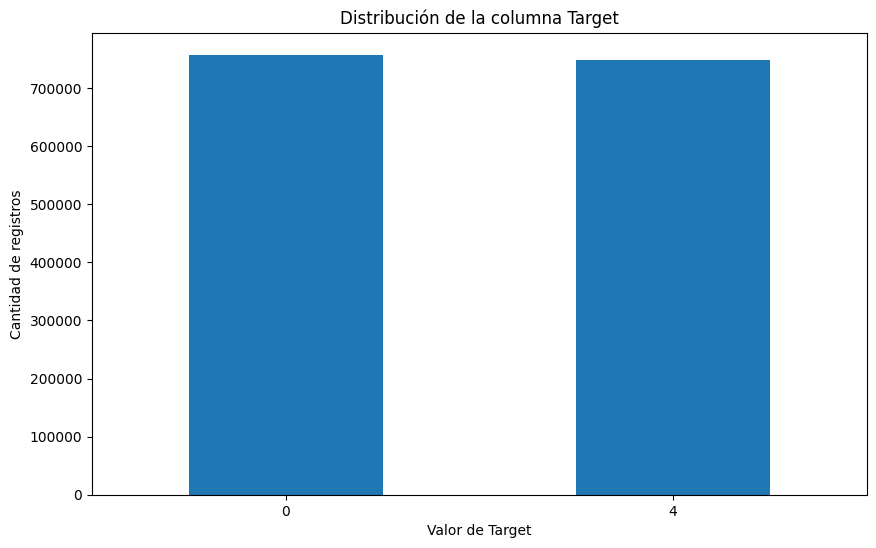

In [ ]:
# Crear el gráfico de barras
conteo_target.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Valor de Target')
plt.ylabel('Cantidad de registros')
plt.title('Distribución de la columna Target')
plt.xticks(rotation=0)
plt.show()

<p align="justify">Observando en detalle tanto el gráfico como el conteo, podemos observar que tenemos aproximadamente la misma cantidad de registros tanto de clase 4 como de la clase 0. Es decir más adelante para nuestro modelo, no tenemos que preocuparnos por tener un clase desbalanceada.</p>

Vamos a observar que usuarios son los que más tweet han generado para seguir con nuestro investigación anterior.

In [ ]:
# Contar la cantidad de tweets por usuario
tweets_por_usuario = df['user'].value_counts().head(100)
tweets_por_usuario.sum()

15870

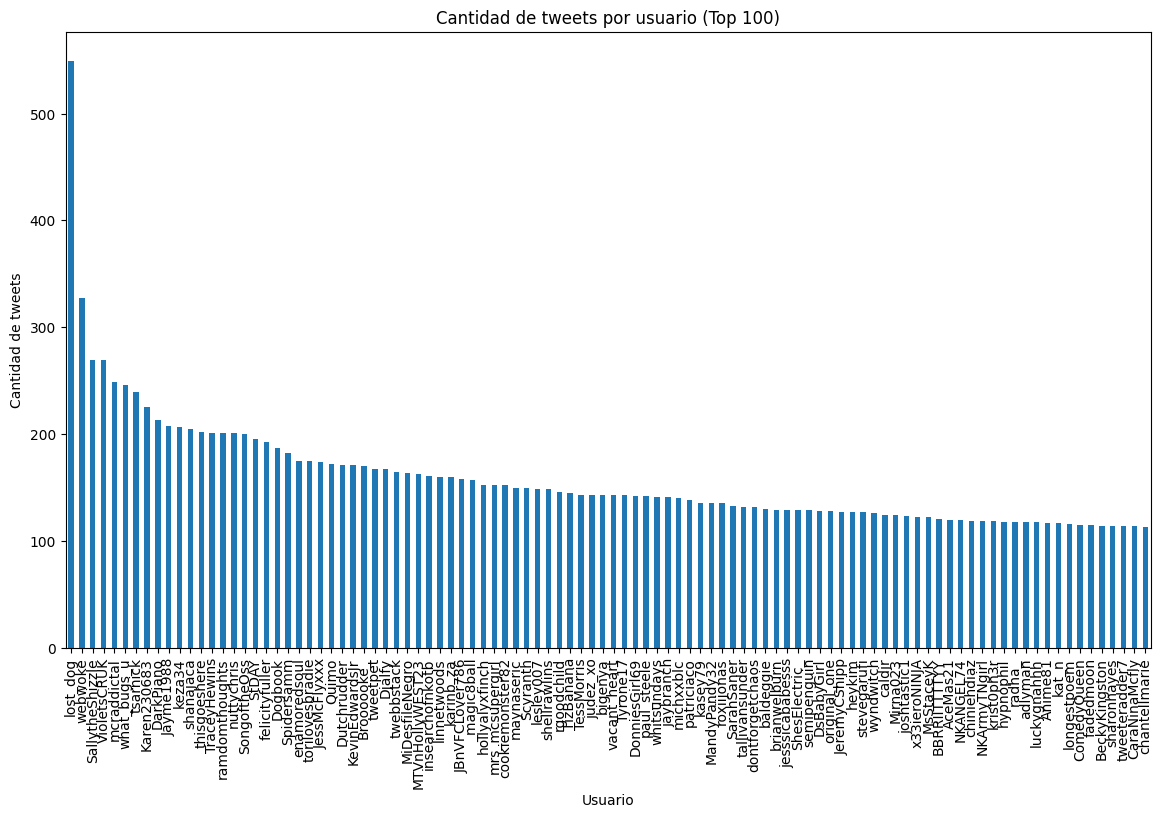

In [ ]:
# Crear el gráfico de barras
# Configurar el gráfico para que no muestre la salida detallada
plt.ioff()

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(14, 8))
tweets_por_usuario.plot(kind='bar', ax=ax)
ax.set_xlabel('Usuario')
ax.set_ylabel('Cantidad de tweets')
ax.set_title('Cantidad de tweets por usuario (Top 100)')
ax.set_xticklabels(tweets_por_usuario.index, rotation=90)

# Mostrar el gráfico
plt.show()

# Volver a activar la salida de matplotlib
plt.ion()

<p align="justify">Podemos observar que entre los primeros 100 usuarios, que más tweets han generado, tenemos que el primero tiene apenas un cantidad de 549 tweet y empieza ha bajar hasta que el usuario número 100 en el conteo tiene 120 tweet, esto solo representa una pequeña parte de todo los tweets del dataframe por usuario, es decir no es necesario eliminar ninguno de estos tweets, ya que según la cantidad total, esto no afectara en gran manera  nuestro modelo de clasificación más adelante. </p>

Vamos a analizar las fechas en las que los tweets se generaron

In [ ]:
# Convertir la columna 'date' a tipo datetime
df['date'] = pd.to_datetime(df['date'])

df.info()

<ipython-input-22-d733647ada39>:2: FutureWarning: Parsed string "Mon Apr 06 22:19:49 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'])


<class 'pandas.core.frame.DataFrame'>
Index: 1505981 entries, 0 to 1599998
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   target        1505981 non-null  int64         
 1   ids           1505981 non-null  int64         
 2   date          1505981 non-null  datetime64[ns]
 3   flag          1505981 non-null  object        
 4   user          1505981 non-null  object        
 5   text          1505981 non-null  object        
 6   cleaned_text  1505981 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 91.9+ MB


In [ ]:
df.head()

,target,ids,date,flag,user,text,cleaned_text
0,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
1,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...
2,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
3,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...
4,0,1467811372,2009-04-06 22:20:00,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,Kwesidei not the whole crew


In [ ]:
# Contar la cantidad de tweets por fecha
tweets_por_fecha = df['date'].dt.date.value_counts().sort_index()
tweets_por_fecha.head()

,count
date,
2009-04-06,3167
2009-04-07,16384
2009-04-17,2937
2009-04-18,20619
2009-04-19,25929


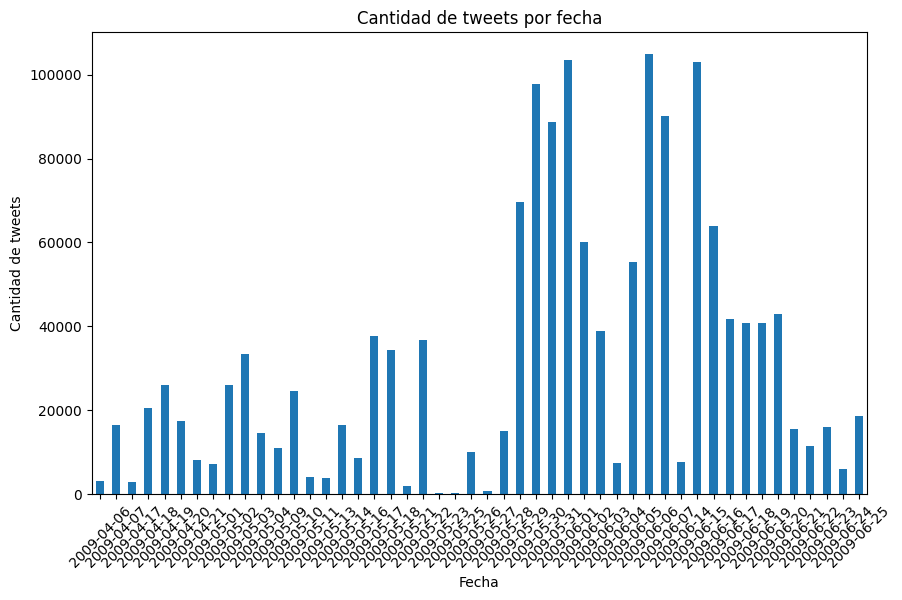

In [ ]:
# Crear el gráfico de barras
tweets_por_fecha.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Fecha')
plt.ylabel('Cantidad de tweets')
plt.title('Cantidad de tweets por fecha')
plt.xticks(rotation=45)
plt.show()

Longitud del tweet: se debe calcular la longitud del texto del tweet en su versión limpia (número de caracteres).
Esta característica es útil porque podría revelar patrones sobre la longitud y el contenido de los tweets.

In [ ]:
def tweet_length(text):
    return len(text)
df['tweet_length'] = df['cleaned_text'].apply(tweet_length)

Contar emojis: en algunos casos, los emojis pueden representar emociones, por lo tanto, contamos cuántos emojis hay en el tweet.
La función debe recorrer cada carácter del texto y contar cuántos son emojis.

In [ ]:
def count_emojis(text):
    return sum(1 for char in text if char in emoji.EMOJI_DATA)

# Aplicando la función para contar emojis en df
df['emoji_count'] = df['text'].apply(count_emojis)

# Mostrar los registros filtrados
df.head()

,target,ids,date,flag,user,text,cleaned_text,tweet_length,emoji_count
0,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,104,0
1,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...,82,0
2,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,46,0
3,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...,101,0
4,0,1467811372,2009-04-06 22:20:00,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,Kwesidei not the whole crew,27,0


Contar signos de exclamación e interrogación: los tweets con muchos signos de exclamación o interrogación podrían indicar emoción o sorpresa.

In [ ]:
def exclamation_count(text):
    return text.count('!')

def question_count(text):
    return text.count('?')


df['exclamation_count'] = df['text'].apply(exclamation_count)
df['question_count'] = df['text'].apply(question_count)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1505981 entries, 0 to 1599998
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   target             1505981 non-null  int64         
 1   ids                1505981 non-null  int64         
 2   date               1505981 non-null  datetime64[ns]
 3   flag               1505981 non-null  object        
 4   user               1505981 non-null  object        
 5   text               1505981 non-null  object        
 6   cleaned_text       1505981 non-null  object        
 7   tweet_length       1505981 non-null  int64         
 8   emoji_count        1505981 non-null  int64         
 9   exclamation_count  1505981 non-null  int64         
 10  question_count     1505981 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 137.9+ MB


In [ ]:
df[df["exclamation_count"]>5]

,target,ids,date,flag,user,text,cleaned_text,tweet_length,emoji_count,exclamation_count,question_count
203,0,1467862355,2009-04-06 22:33:13,NO_QUERY,Britty88,@cheechbud i think ur right!! hahaha!! 4.5 hrs...,cheechbud i think ur right hahaha hrs now,41,0,6,0
355,0,1467900431,2009-04-06 22:43:29,NO_QUERY,cescajo,last one!!! but still not done!!!,last one but still not done,27,0,6,0
361,0,1467901346,2009-04-06 22:43:46,NO_QUERY,gildardomunoz,DANG!!! ANOTHER SPRING BREAK!!! HOW COOL IS T...,DANG ANOTHER SPRING BREAK HOW COOL IS THAT TOO...,119,0,9,3
427,0,1467918850,2009-04-06 22:48:38,NO_QUERY,sthrn_belle,My Pookie has a UTI. I have to be Nurse Gabbi...,My Pookie has a UTI I have to be Nurse Gabbie ...,79,0,17,0
469,0,1467930341,2009-04-06 22:51:53,NO_QUERY,GemDoughnut,MORNING!!! Good im bloody knackered!!! Work is...,MORNING Good im bloody knackered Work is not f...,68,0,10,0
...,...,...,...,...,...,...,...,...,...,...,...
1599650,4,2193502245,2009-06-16 08:32:41,NO_QUERY,CokieTheCat,SissyDawnie: @CokieTheCat - Marvelous on 10 ca...,SissyDawnie CokieTheCat Marvelous on cancerfre...,104,0,9,0
1599691,4,2193503813,2009-06-16 08:32:49,NO_QUERY,MontriaAnderson,@gospelpundit YES!!!! WhOo HoOo!!!,gospelpundit YES WhOo HoOo,26,0,7,0
1599801,4,2193529779,2009-06-16 08:34:56,NO_QUERY,maeubhminor,woooo elliot minor in 8 days!!! and i got my E...,woooo elliot minor in days and i got my EM hoo...,120,0,6,0
1599938,4,2193576737,2009-06-16 08:38:47,NO_QUERY,ajenne,OMG!!!!!!!!!! My dad will be having surgery to...,OMG My dad will be having surgery today Please...,71,0,10,0


In [ ]:
# Calcular densidad de palabras
def capital_word_density_regex(text):
    words = re.findall(r'\b\w+\b', text)
    total_words = len(words)
    capital_words = sum(1 for word in words if word.isupper())
    if total_words == 0:
        return 0
    return capital_words / total_words

# Contar palabras usando split()
def word_count_split(text):
    return len(text.split())


# Aplicar la función al DataFrame
df['capital_word_density'] = df['cleaned_text'].apply(capital_word_density_regex)

# Aplicar la función al DataFrame
df['word_count'] = df['cleaned_text'].apply(word_count_split)

In [ ]:
stop_words = set(stopwords.words('english'))

# 6 Función para contar stopwords
def stopword_count(text):
    words = text.split()
    return sum(1 for word in words if word.lower() in stop_words)

# 7 Función para contar palabras únicas
def unique_word_count(text):
    words = text.split()
    return len(set(words))

# 8 Función para calcular la proporción de palabras repetidas usando expresiones regulares
def repeated_word_proportion_regex(text):
    words = re.findall(r'\b\w+\b', text)
    total_words = len(words)
    unique_words = len(set(words))
    if total_words == 0:
        return 0
    return (total_words - unique_words) / total_words


# Aplicar la función de stopword_coun al df
df['stopword_count'] = df['cleaned_text'].apply(stopword_count)

# Aplicar la función de unique_word_count al df
df['unique_word_count'] = df['cleaned_text'].apply(unique_word_count)

# Aplicar la función de
df['repeated_word_proportion'] = df['cleaned_text'].apply(repeated_word_proportion_regex)

In [ ]:
# 9 Función para contar signos de puntuación usando expresiones regulares
def punctuation_count(text):
    return len(re.findall(r'[^\w\s]', text))

# 10

## Función para contar menciones usando expresiones regulares
def mention_count(text):
    return len(re.findall(r'@\w+', text))

## Función para contar hashtags usando expresiones regulares
def hashtag_count(text):
    return len(re.findall(r'#\w+', text))


# Aplicando la función punctuation_count al df
df['punctuation_count'] = df['cleaned_text'].apply(punctuation_count)

# Aplicando las funciones mention_count y hashtag_count al df
df['mention_count'] = df['cleaned_text'].apply(mention_count)
df['hashtag_count'] = df['cleaned_text'].apply(hashtag_count)


In [ ]:

#11 Longitud promedio de palabras
def avg_word_length(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words) if words else 0

#11 Funcines para contar la cantidad de emoticones positivos y negativos
def count_positivos(text):
    emoticonos_positivos = r'(:\)|:D|:P)'  # Añade los emoticonos positivos
    return len(re.findall(emoticonos_positivos, text))

def count_negativos(text):
    emoticonos_negativos = r'(:\(|D:|:c|:\')'  # Añade los emoticonos negativos
    return len(re.findall(emoticonos_negativos, text))

# Aplicando la función avg_word_length al df

df['avg_word_length'] = df['cleaned_text'].apply(avg_word_length)
# Aplicando las funciones count_positivos y count_negativos al df

df['emoticonos_positivos'] = df['text'].apply(count_positivos)
df['emoticonos_negativos'] = df['text'].apply(count_negativos)



In [ ]:
# Eliminando columnas
df=df.drop(columns=['ids','date','flag','user'])

In [ ]:
df.head()

,target,text,cleaned_text,tweet_length,emoji_count,exclamation_count,question_count,capital_word_density,word_count,stopword_count,unique_word_count,repeated_word_proportion,punctuation_count,mention_count,hashtag_count,avg_word_length,emoticonos_positivos,emoticonos_negativos
0,0,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,104,0,1,0,0.000000,21,9,21,0.000000,0,0,0,4.000000,0,0
1,0,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...,82,0,0,0,0.058824,17,7,17,0.000000,0,0,0,3.882353,0,0
2,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,46,0,0,0,0.000000,10,4,10,0.000000,0,0,0,3.700000,0,0
3,0,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...,101,0,0,1,0.047619,21,15,20,0.047619,0,0,0,3.857143,0,0
4,0,@Kwesidei not the whole crew,Kwesidei not the whole crew,27,0,0,0,0.000000,5,2,5,0.000000,0,0,0,4.600000,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1505981 entries, 0 to 1599998
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   target                    1505981 non-null  int64  
 1   text                      1505981 non-null  object 
 2   cleaned_text              1505981 non-null  object 
 3   tweet_length              1505981 non-null  int64  
 4   emoji_count               1505981 non-null  int64  
 5   exclamation_count         1505981 non-null  int64  
 6   question_count            1505981 non-null  int64  
 7   capital_word_density      1505981 non-null  float64
 8   word_count                1505981 non-null  int64  
 9   stopword_count            1505981 non-null  int64  
 10  unique_word_count         1505981 non-null  int64  
 11  repeated_word_proportion  1505981 non-null  float64
 12  punctuation_count         1505981 non-null  int64  
 13  mention_count             150598

In [ ]:
# Ver los valores únicos de la columna target
valores_unicos_target = df['target'].unique()
print(f"Valores únicos de la columna target: {valores_unicos_target}")

Valores únicos de la columna target: [0 4]


## Es tu turno! ¿Qué otras variables se te ocurren para poder construir un modelo que pueda predecir el sentimiento del tweet?

**Existen librerías que ya detectan los sentimientos de texto, crees que debas de usarlas?**

In [ ]:
df.to_csv('datatotal.csv')